In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import plotly.express as px
import seaborn as sns
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, ConvLSTM1D, ReLU, LeakyReLU, Softmax, Flatten, Dropout, Dense, Reshape
# from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from datetime import datetime
import math

### import and visualize the Data

In [2]:
# importing dataset
D = pd.read_csv('GOOG.csv')
D.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [3]:
print('NA values:',D.isnull().values.any())

NA values: False


C:\Users\Mina\AppData\Local\Temp\ipykernel_13380\2627227549.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


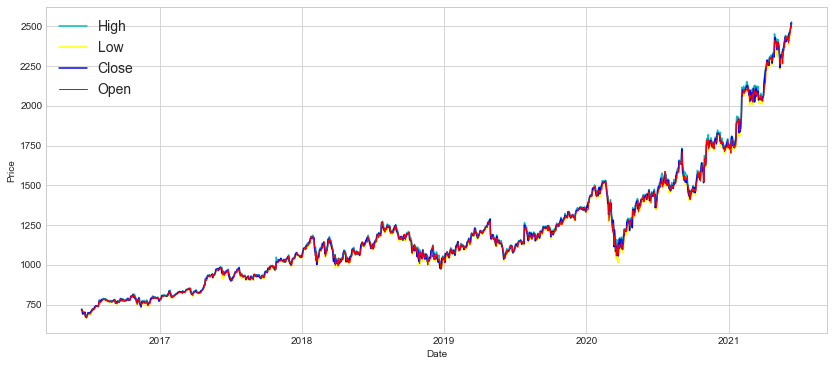

In [4]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14,6))
a = pd.to_datetime(D['date'])
b = D['open']
c = D['close']
d = D['high']
e = D['low']
plt.xlabel(xlabel='Date')
plt.ylabel(ylabel='Price')

plt.plot(a, d, color='c', label='High');
plt.plot(a, e, color='yellow', label='Low');
plt.plot(a, c, color='blue', label='Close');
plt.plot(a, b, color='red', label='Open', linewidth=1);
plt.legend(prop={'size':14});

In [207]:
# stock open, close, high & low distribution over time

fig = px.line(D, x=D.date, y=[D['close'], D['high'], D['low'],D['open']],
             labels={'date': 'Date','value':'Price'},width=1000, height=400)
fig.update_layout(title_text='Stock Diagram', font_size=15, font_color='black',legend_title_text='')
fig.show()

### add datetime features

In [5]:
# adding month and day of week columns to the dataset
D['date'] = pd.to_datetime(D['date'])
D['date'] = [d.date() for d in D['date']]
D['weekday'] = [d.weekday() for d in D['date']]
D['month'] = pd.DatetimeIndex(D['date']).month

In [6]:
# monthwise open and close price
T = pd.DataFrame()
T[['month', 'open', 'close']] = D[['month', 'open', 'close']]
months = {0:'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June', 6:'July', 7:'August', 
             8:'September', 9:'October', 10:'November', 11:'December'}

T['month'] = T['month'].map(months)
monthvise= T.groupby(T['month'])[['open','close']].mean()

fig = pgo.Figure()
fig.add_trace(pgo.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Open Price',
))
fig.add_trace(pgo.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Close Price',
    marker_color='orange'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, width=800, height=400,
                  title='Monthwise comparision - open and close price')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

In [7]:
D.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,weekday,month
0,GOOG,2016-06-14,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0,1,6
1,GOOG,2016-06-15,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0,2,6
2,GOOG,2016-06-16,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0,3,6
3,GOOG,2016-06-17,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0,4,6
4,GOOG,2016-06-20,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0,0,6


In [8]:
# converting month and day of week to loop format
D['weekday'] = [np.sin((i+1)/7) for i in D['weekday']]
D['month'] = [np.sin((i+1)/31) for i in D['month']]

In [9]:
# correlation between attributes
corr = D[['open', 'close', 'high', 'low', 'weekday', 'month']].corr()
fig = px.imshow(corr, text_auto=True)
fig.update_layout(width=700, height=550, title='Correlation Plot')
fig.show()

### preparing the final Data

In [182]:
# a function to return train and test data
def set_data(Data, col_name, start_samples, num_test):
    if type(Data) != 'pandas.core.frame.DataFrame':
        Data = pd.DataFrame(Data)
    DataX = Data[[col_name]]
    # 'close', 'high', 'low', 'weekday', 'month']]
    scaler = MinMaxScaler()
    DataX = scaler.fit_transform(DataX)
    DataY = DataX[: , 0]

    X = []
    y = []
    for i in range(start_samples , Data.shape[0]-1):
        X.append(DataX[i-start_samples:i, :])
        y.append(DataY[i+1])
    s = len(X) 
    
    X_train = X[:s-num_test]
    y_train = y[:s-num_test]
    X_test = X[s-num_test:]
    y_test = y[s-num_test:]

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

### Model for "Open" column

In [183]:
test_size = 100 # number of samples for final test.
start_samples = 50 # number of samples which will be used to predict next day.
n = 30 # last n days result that model will predict all by itself.
X_train, y_train, X_test, y_test = set_data(D,col_name='open', start_samples=start_samples, num_test=test_size + n)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1077, 50, 1) (1077,)
(130, 50, 1) (130,)


In [194]:
tf.random.set_seed(100)
model=Sequential()
model.add(GRU(64,return_sequences=True,input_shape=(start_samples,1)))
model.add(GRU(64,return_sequences=True))
model.add(GRU(64))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [195]:
h = model.fit(X_train, y_train, epochs=10, batch_size=8)

Epoch 1/10
135/135 [==============================] - 12s 34ms/step - loss: 0.0023
Epoch 2/10
135/135 [==============================] - 4s 33ms/step - loss: 7.1534e-04
Epoch 3/10
135/135 [==============================] - 4s 33ms/step - loss: 9.4879e-04
Epoch 4/10
135/135 [==============================] - 4s 33ms/step - loss: 5.9800e-04
Epoch 5/10
135/135 [==============================] - 4s 33ms/step - loss: 5.8282e-04
Epoch 6/10
135/135 [==============================] - 4s 33ms/step - loss: 5.1364e-04
Epoch 7/10
135/135 [==============================] - 4s 33ms/step - loss: 4.5612e-04
Epoch 8/10
135/135 [==============================] - 4s 33ms/step - loss: 4.9484e-04
Epoch 9/10
135/135 [==============================] - 4s 33ms/step - loss: 5.1396e-04
Epoch 10/10
135/135 [==============================] - 4s 33ms/step - loss: 4.2319e-04


In [196]:
y_pred = model.predict(X_test[:test_size])

4/4 [==============================] - 1s 17ms/step


In [198]:
DF = pd.DataFrame()
DF[['time']] = pd.DataFrame(list(range(0,test_size, 1)))
DF[['test']] = pd.DataFrame(y_test[:test_size])
DF[['pred']] = pd.DataFrame(y_pred)
fig = px.line(DF, x=DF['time'], y=[DF['test'], DF['pred']],
             labels={'date': 'Date','value':'Price'},width=1000, height=500)
fig.update_layout(title_text='Stock Diagram - predict vs real', font_size=15, font_color='black',legend_title_text='')
fig.show()

### Predicting Next 30 Days

In [199]:
def next_n_days(X_test, n):
    x = X_test[-1:]
    y = []
    pred = model.predict(x)
    x = np.append(x[0], [pred[-1]], axis=0)
    y.append(pred)

    for i in range(n-1):
        pred = model.predict(x[-50:].reshape(1,50,1))
        x = np.append(x, [pred[-1]], axis=0)
        y.append(pred)

    return y

In [200]:
y_next_n_days  = next_n_days(X_test[:test_size], n)

1/1 [==============================] - 0s 30ms/step


In [201]:
DF = pd.DataFrame()
DF[['time']] = pd.DataFrame(list(range(0, test_size + n, 1)))
DF[['test']] = pd.DataFrame(y_test)
DF[['pred']] = pd.DataFrame(np.concatenate((np.array(y_pred), np.array(y_next_n_days).reshape(n,1)), axis=0))
fig = px.line(DF, x=DF['time'], y=[DF['test'], DF['pred']],
             labels={'date': 'Date','value':'Price'},width=1000, height=500)
fig.update_layout(title_text='Stock Diagram - predict vs real', font_size=15, font_color='black',legend_title_text='')
fig.show()

### Model for "Close" column

In [202]:
X_train, y_train, X_test, y_test = set_data(D,col_name='close', start_samples=start_samples, num_test=test_size + n)

In [203]:
model2 = Sequential( layers= [
    Dense(100, input_shape = (start_samples,1)),
    Reshape((1,50,100)),
    ConvLSTM1D(filters=30, kernel_size=5),
    Flatten(),
    Dense(15),
    Dense(1)
])

model2.compile(loss='mean_squared_error', optimizer=Adam(), metrics = MeanAbsoluteError())

In [204]:
h2 = model2.fit(X_train, y_train, epochs=10, batch_size=8)

Epoch 1/10
135/135 [==============================] - 18s 68ms/step - loss: 0.0040 - mean_absolute_error: 0.0391
Epoch 2/10
135/135 [==============================] - 9s 65ms/step - loss: 9.5068e-04 - mean_absolute_error: 0.0211
Epoch 3/10
135/135 [==============================] - 9s 65ms/step - loss: 8.4645e-04 - mean_absolute_error: 0.0212
Epoch 4/10
135/135 [==============================] - 9s 65ms/step - loss: 6.4763e-04 - mean_absolute_error: 0.0188
Epoch 5/10
135/135 [==============================] - 9s 67ms/step - loss: 5.5021e-04 - mean_absolute_error: 0.0172
Epoch 6/10
135/135 [==============================] - 9s 68ms/step - loss: 4.4099e-04 - mean_absolute_error: 0.0154
Epoch 7/10
135/135 [==============================] - 10s 72ms/step - loss: 4.2648e-04 - mean_absolute_error: 0.0150
Epoch 8/10
135/135 [==============================] - 10s 74ms/step - loss: 4.0328e-04 - mean_absolute_error: 0.0148
Epoch 9/10
135/135 [==============================] - 10s 75ms/step - los

### Predicting Next 30 Days

In [206]:
y_pred = model2.predict(X_test[:test_size])
y_next_n_days  = next_n_days(X_test[:test_size], n)

DF = pd.DataFrame()
DF[['time']] = pd.DataFrame(list(range(0, test_size + n, 1)))
DF[['test']] = pd.DataFrame(y_test)
DF[['pred']] = pd.DataFrame(np.concatenate((np.array(y_pred), np.array(y_next_n_days).reshape(n,1)), axis=0))
fig = px.line(DF, x=DF['time'], y=[DF['test'], DF['pred']],
             labels={'date': 'Date','value':'Price'},width=1000, height=500)
fig.update_layout(title_text='Stock Diagram - predict vs real', font_size=15, font_color='black',legend_title_text='')
fig.show()

1/1 [==============================] - 0s 35ms/step
